## Diagnóstico de Cáncer de Mama ##

### Importamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import diagnostico_cancer.src.preprocessing as pr
import diagnostico_cancer.src.data_splitting as ds
import diagnostico_cancer.src.metrics as metrics
import diagnostico_cancer.src.resampling_techniques as rt
from diagnostico_cancer.src.models import LinearRegression, BinaryClassifier

### Hacemos un análisis exploratorio de los datos

In [2]:
dev_path = 'diagnostico_cancer/data/raw/cell_diagnosis_dev.csv'
dev_dataset = pd.read_csv(dev_path)

          CellSize    CellShape  NucleusDensity  ChromatinTexture  \
count  1333.000000  1347.000000     1362.000000       1366.000000   
mean     83.247087     0.598657        2.097344         26.094973   
std     100.316719     0.565438        4.987573         24.842157   
min    -100.000000    -1.413038       -3.000000         10.000000   
25%      66.572149     0.479758        1.397010         21.279126   
50%      69.704323     0.498832        1.445035         22.066810   
75%      72.653147     0.523018        1.485651         22.823319   
max    1000.000000     5.048566       50.000000        263.793425   

       CytoplasmSize  CellAdhesion  MitosisRate  NuclearMembrane  \
count    1347.000000   1369.000000  1343.000000      1343.000000   
mean       33.989815      0.548800     5.326484         2.825365   
std        32.809627      0.612232    11.572456         2.697956   
min         5.000000     -4.461755   -50.000000        -3.438990   
25%        26.304514      0.456400    

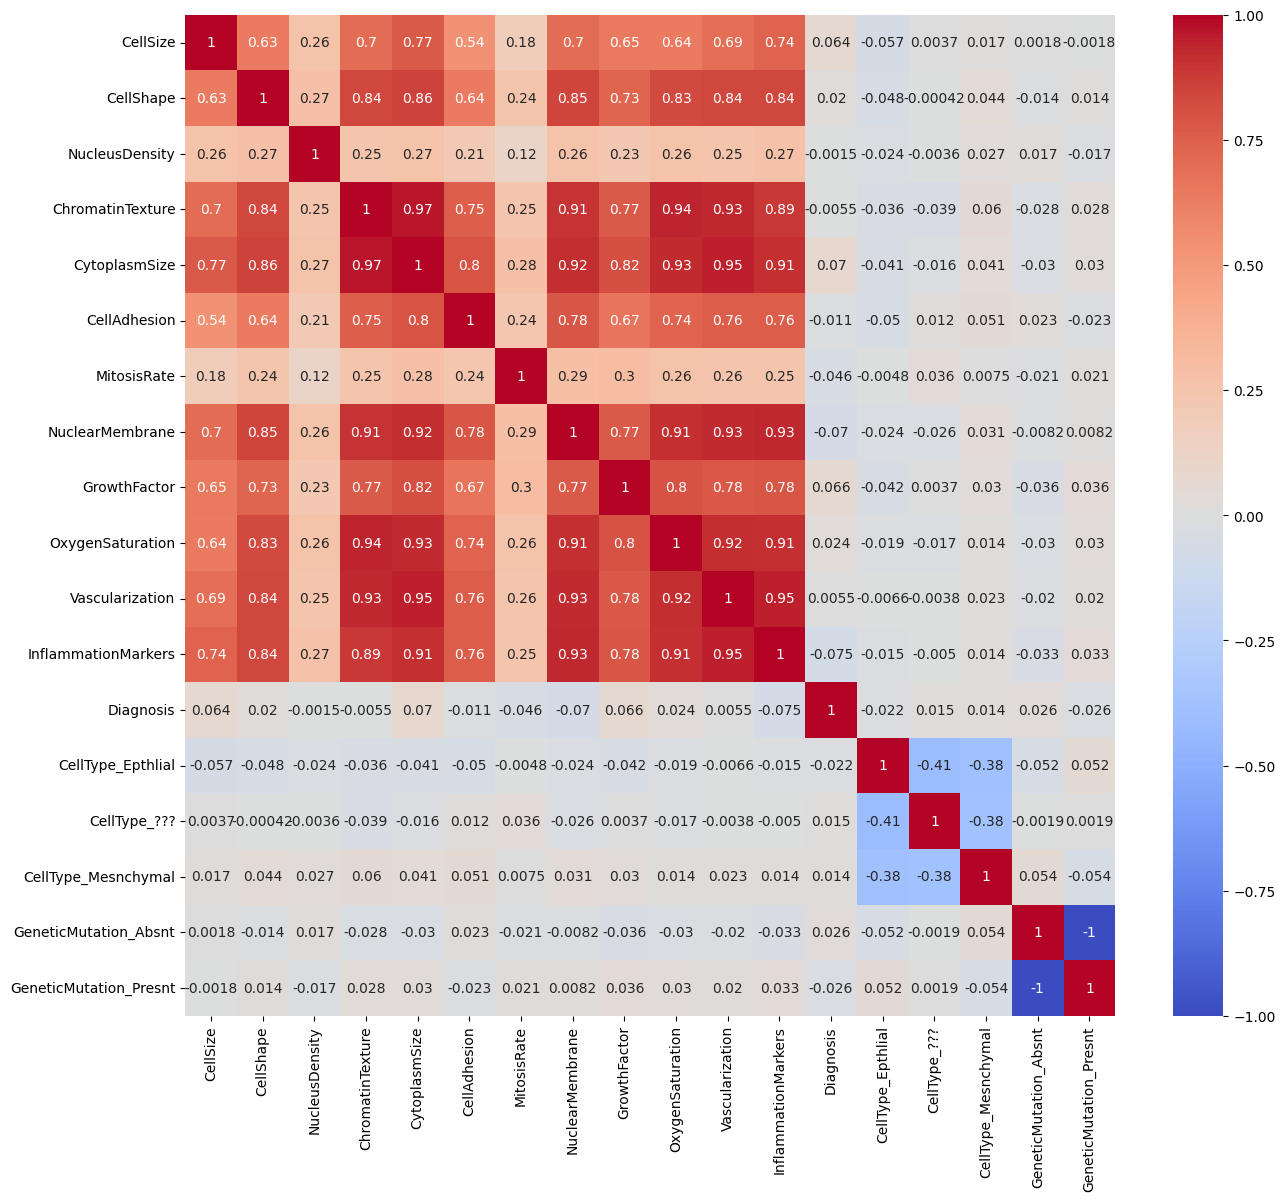

<Axes: >

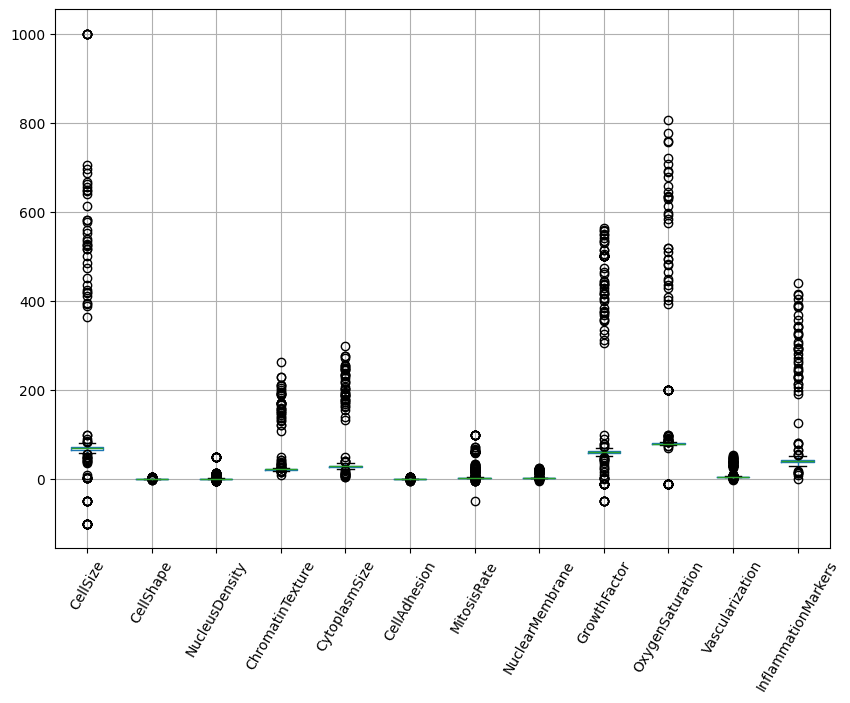

In [3]:
data_description = dev_dataset.describe()
print(data_description)

missing_values = dev_dataset.isnull().sum()  # Cantidad de valores faltantes por columna
print(missing_values)

target_values = dev_dataset['Diagnosis'].value_counts()
print(target_values)

numeric_cols_range = {
    'CellSize': (0, np.inf), 'CellShape': (-np.inf, np.inf), 'NucleusDensity': (0, np.inf), 
    'ChromatinTexture': (-np.inf, np.inf), 'CytoplasmSize': (0, np.inf), 'CellAdhesion':(0, 1), 
    'MitosisRate': (0, np.inf), 'NuclearMembrane': (1, 5), 'GrowthFactor': (-np.inf, np.inf), 
    'OxygenSaturation': (0, 100), 'Vascularization': (0, 10), 'InflammationMarkers': (0, 100)
}

categorical_cols = [
    'CellType', 'GeneticMutation'
]

numeric_cols = list(numeric_cols_range.keys())

pr.corr_matrix(dev_dataset, categorical_columns=categorical_cols)
dev_dataset.boxplot(numeric_cols, rot=60, grid=True, figsize=(10, 7))


# GRAFICAR DATOS Y VER QUE TAN ALEJADOS ESTAN
# hacer docstrings de todo

# VER SI ME CONVIENE DEJAR OUTLIERS -> EJEMPLO DE SI SOY UN MEDICO Y ME VIENE UN PACIENTE CON UN OUTLIER, NO LO TRATO? NECESITO QUE MI MODELO APRENDA CON ALGUNOS OUTLIERS

# IMPORTANTE!!!! LOS OUTLIERS DE TEST NO PUIEDO TOCARLOS. YO NO PUEDO TOCAR EL CONJUNTO DE TEST.

### Limpiamos el dataset

Number of outliers replaced in column [CellSize]: 88
Number of outliers replaced in column [CellShape]: 87
Number of outliers replaced in column [NucleusDensity]: 115
Number of outliers replaced in column [ChromatinTexture]: 65
Number of outliers replaced in column [CytoplasmSize]: 61
Number of outliers replaced in column [CellAdhesion]: 84
Number of outliers replaced in column [MitosisRate]: 109
Number of outliers replaced in column [NuclearMembrane]: 78
Number of outliers replaced in column [GrowthFactor]: 94
Number of outliers replaced in column [OxygenSaturation]: 90
Number of outliers replaced in column [Vascularization]: 73
Number of outliers replaced in column [InflammationMarkers]: 53
     CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
0   63.423148   0.500594        1.473261         23.300222      25.731676   
1   72.906362   0.474808        1.361360         21.336137      29.856233   
2   70.711969   0.481701        1.396741         21.521406      30.

<Axes: >

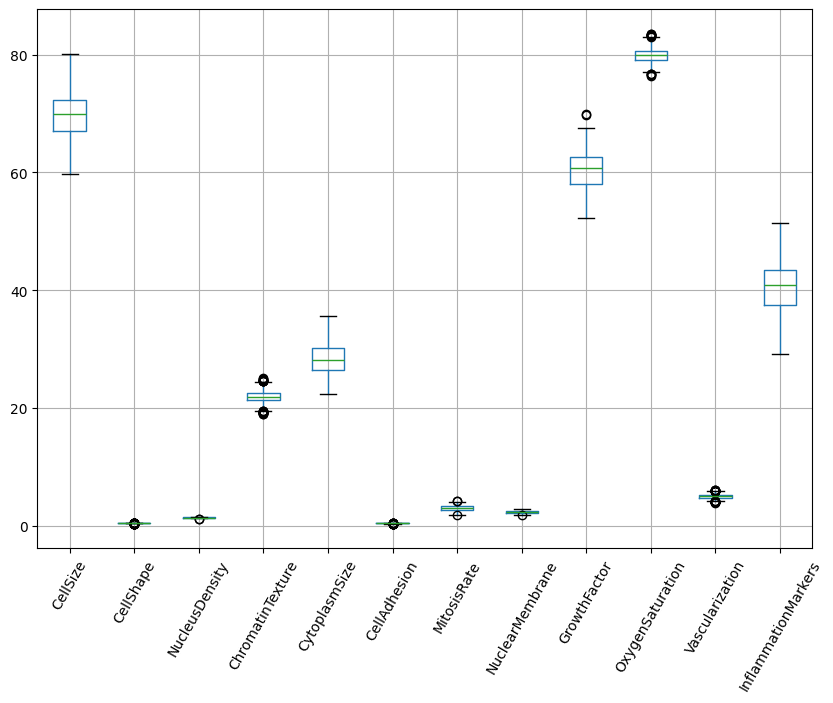

In [4]:
# dev_dataset = pr.remove_missing_rows(dev_dataset, threshold=35) # Remuevo las filas que tienen más de 35% nans (JUSTIFICAR)

dev_dataset = pr.replace_unwanted_values(dev_dataset, col_range=numeric_cols_range, cat_columns=categorical_cols, keywords=['???'])
dev_dataset = pr.handle_missing_values(dev_dataset, numeric_cols=numeric_cols, categorical_cols=categorical_cols)
original_dev_dataset = dev_dataset.copy() # guardo el dataset antes del one hot para usar en el knn del test
dev_dataset = pr.one_hot_encoder(dev_dataset, columns=categorical_cols)
print(dev_dataset.head(20)) 

dev_dataset.boxplot(numeric_cols, rot=60, grid=True, figsize=(10, 7))

# KNN EN TEST UYSANDO LOS DATOS DE TRAIN


### Entrenamos el modelo

#### Buscamos el mejor parámetro de regularización

In [5]:
columns_to_normalize = [
    'CellSize', 'CellShape', 'NucleusDensity', 'ChromatinTexture',
    'CytoplasmSize', 'MitosisRate', 'NuclearMembrane',
    'GrowthFactor', 'OxygenSaturation', 'Vascularization', 'InflammationMarkers'
]

train_df, valid_df = ds.train_val_split(dev_dataset, seed=42, train_size=0.8)
original_train_df = original_dev_dataset.loc[train_df.index] # Guardo este dataset para usar knn en test
train_df, valid_df = pr.normalize_train_test(train_df, valid_df, columns=columns_to_normalize)

possible_lambdas = np.logspace(-3, 1, 5).tolist()
avg_lambdas = ds.cross_val(valid_df, target_name='Diagnosis', lambda_values=possible_lambdas, k=5)

# me da que no me conviene regularizar

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Cross-validation folds: 100%|██████████| 5/5 [00:56<00:00, 11.26s/it]

F-scores for each fold and lambda value:
     0.001     0.010     0.100     1.000     10.000
1  0.909091  0.909091  0.909091  0.909091  0.892308
2  0.977778  0.977778  0.977778  0.977778  0.977778
3  0.900000  0.900000  0.900000  0.900000  0.857143
4  0.935484  0.935484  0.952381  0.952381  0.952381
5  0.929577  0.929577  0.929577  0.929577  0.898551
Average F-scores for each lambda value
Lambda 0.001: F-score = 0.9304
Lambda 0.01: F-score = 0.9304
Lambda 0.1: F-score = 0.9338
Lambda 1.0: F-score = 0.9338
Lambda 10.0: F-score = 0.9156


### Muestro las métricas

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Cross-validation folds: 100%|██████████| 5/5 [02:02<00:00, 24.47s/it]

F-scores for each fold and threshold:
        0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
1  0.646465  0.842105  0.927536  0.909091  0.909091  0.909091  0.909091   
2  0.494382  0.916667  0.956522  0.977778  0.977778  0.977778  0.977778   
3  0.604167  0.840580  0.875000  0.900000  0.900000  0.900000  0.881356   
4  0.639175  0.837838  0.909091  0.952381  0.952381  0.935484  0.935484   
5  0.705882  0.923077  0.931507  0.916667  0.916667  0.929577  0.898551   

        0.7       0.8       0.9  1.0  
1  0.875000  0.833333  0.750000  0.0  
2  0.977778  0.930233  0.820513  0.0  
3  0.862069  0.814815  0.750000  0.0  
4  0.950820  0.915254  0.720000  0.0  
5  0.878788  0.825397  0.615385  0.0  
Average F-scores for each threshold
Threshold 0.00: F-score = 0.6180
Threshold 0.10: F-score = 0.8721
Threshold 0.20: F-score = 0.9199
Threshold 0.30: F-score = 0.9312
Threshold 0.40: F-score = 0.9312
Threshold 0.50: F-score = 0.9304
Threshold 0.60: F-score = 0.9205
Threshold 

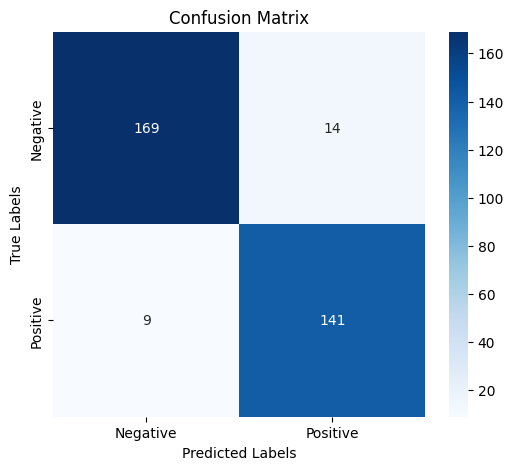

MODEL ACCURACY: 0.9309309309309309
MODEL PRECISION: 0.9096774193548387
MODEL RECALL: 0.94
MODEL F-SCORE: 0.9245901639344263


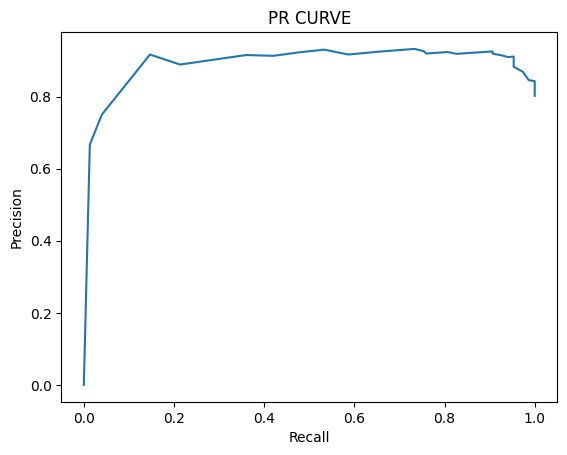

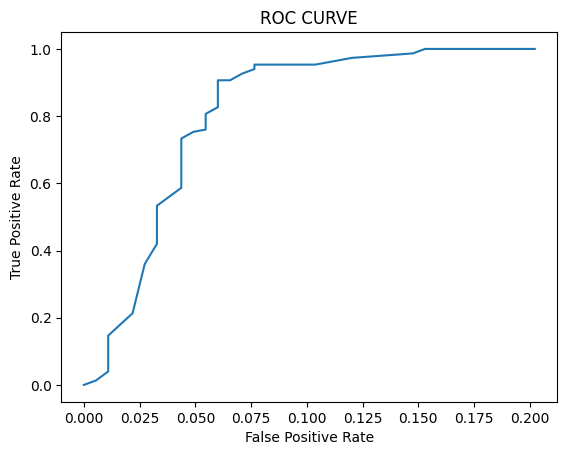

MODEL AUC-ROC: 0.1629143897996357
MODEL AUC-PR: 0.8917134787165856


In [6]:
model = BinaryClassifier(train_df, target_name='Diagnosis', ridge_lambda=0.1, threshold=0.5, fit=True)

# Generate predictions for the training data
valid_features = valid_df.drop(columns=['Diagnosis']).values
valid_predictions = model.predict(valid_features)

results = pd.DataFrame({
    'Diagnosis': valid_df['Diagnosis'],
    'Prediction': valid_predictions
})

model_stats = metrics.extract_results(results)

thresholds_val = np.linspace(0, 1, 11).tolist()
avg_thresholds = metrics.cross_val_threshold(valid_df, target_name='Diagnosis', threshold_values=thresholds_val, lmbda=0, k=5)

metrics.print_metrics(model_stats)

possible_thresholds = np.linspace(0.1, 1, 51).tolist()
threshold_metrics = metrics.get_thresholds_results(possible_thresholds, train_df, valid_df, target_name='Diagnosis')

prec, rec = metrics.precision_recall_curve(threshold_metrics)
tpr, fpr = metrics.roc_curve(threshold_metrics)
print(f'MODEL AUC-ROC: {metrics.auc_roc(tpr, fpr)}')
print(f'MODEL AUC-PR: {metrics.auc_pr(prec, rec)}')


### Evalúo el modelo en el conjunto de test

#### Limpio el dataset de test

In [7]:
test_path = 'diagnostico_cancer/data/raw/cell_diagnosis_test.csv'
test_df = pd.read_csv(test_path)

test_df = pr.replace_missing_values(test_df, columns=categorical_cols, keywords=['???'])
test_df = pr.handle_missing_test_values(test_df, original_train_df, numeric_cols=numeric_cols, categorical_cols=categorical_cols)
test_df = pr.one_hot_encoder(test_df, columns=categorical_cols)

      CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
1448  0.815218   0.149023       -0.590556         -1.552811       0.006814   
168  -0.732237   0.401103        1.474795         -0.576081      -0.742719   
220  -1.315699   0.011613        1.166555          0.898555      -0.543507   
1643 -1.568041  -0.348428        0.695920         -0.592570      -1.006528   
344   0.139912  -0.480642        0.353124         -0.464700      -0.164299   
...        ...        ...             ...               ...            ...   
546   0.585550   0.083750       -1.980701         -1.444823       0.614942   
658  -0.242251  -0.620803       -1.077491         -0.567016       0.590847   
1353 -0.833321  -0.477841        0.676296          0.229416      -1.256097   
1019  1.099580   0.678283       -0.386234          0.058421       1.232456   
1386 -0.023889   0.331389        0.372167         -0.226923      -1.135238   

      CellAdhesion  MitosisRate  NuclearMembrane  GrowthFactor 

### Testeo mi modelo

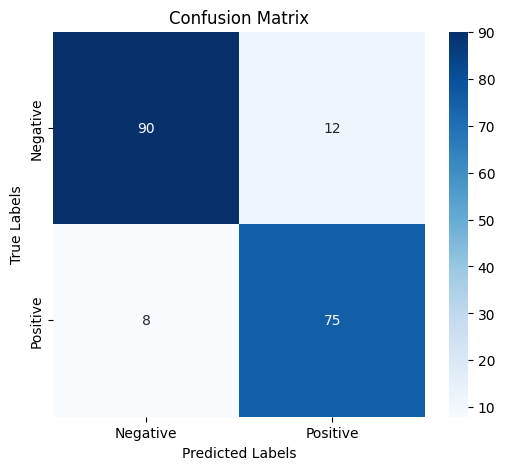

MODEL ACCURACY: 0.8918918918918919
MODEL PRECISION: 0.8620689655172413
MODEL RECALL: 0.9036144578313253
MODEL F-SCORE: 0.8823529411764706


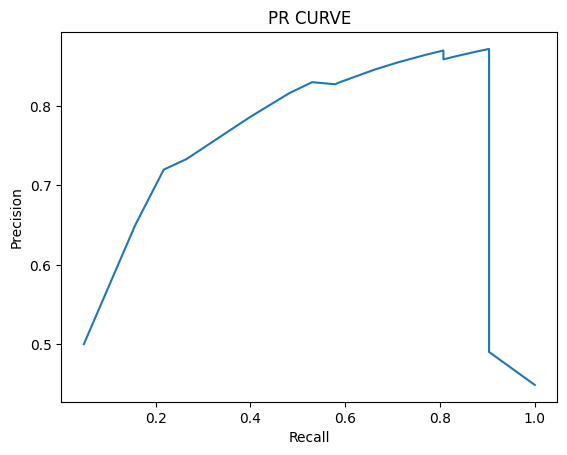

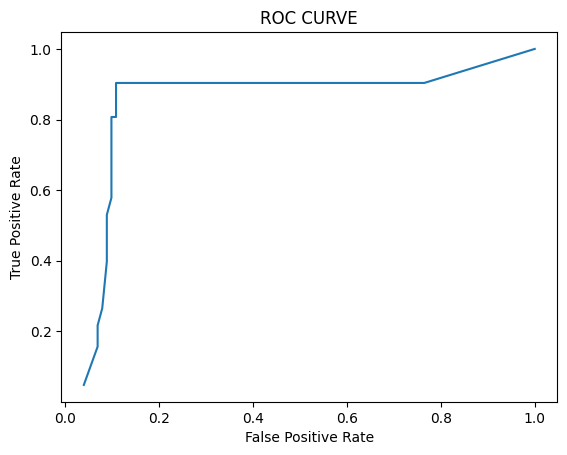

MODEL AUC-ROC: 0.839475549255847
MODEL AUC-PR: 0.7099060163821159


In [8]:
dev_dataset, test_df = pr.normalize_train_test(dev_dataset, test_df, columns=columns_to_normalize)

final_model = BinaryClassifier(dev_dataset, target_name='Diagnosis', ridge_lambda=0, threshold=0.5, fit=True)

test_features = test_df.drop(columns=['Diagnosis']).values
test_predictions = final_model.predict(test_features)

test_results = pd.DataFrame({
    'Diagnosis': test_df['Diagnosis'],
    'Prediction': test_predictions
})

final_model_stats = metrics.extract_results(test_results) # EL KNN CREO Q ESTA MAL XQ LO HAGO CON TRAIN PERO DSP ENTRENO CON DEV (TRAIN + VAL)

# CON QUE ENTRENO?
#   PUEDO ENTRENAR CON TRAIN
#       -> VOY A TENER UNA MEJOR ESTIMACION DEL ERROR XQ JUSTAMENTE HICISTE CROSS VALIDATION ENTRENANDO CON TRAIN
#   O PUEDO ENTRENAR CON TRAIN + VALIDATION
#       -> VOY A TENER UNA PEOR ESTIMACION DEL ERROR XQ ESTAS ENTRENANDO CON OTROS DATOS PERO UNO PODRIA JUSTIFICAR (EN TEORIA) QUE AL ENTRENAR CON MAS DATOS MI MODELO DEBERIA SER MEJOR

metrics.print_metrics(final_model_stats)

f_possible_thresholds = np.linspace(0, 1, 51).tolist()
f_threshold_metrics = metrics.get_thresholds_results(f_possible_thresholds, dev_dataset, test_df, target_name='Diagnosis')

f_prec, f_rec = metrics.precision_recall_curve(f_threshold_metrics)
f_tpr, f_fpr = metrics.roc_curve(f_threshold_metrics)
print(f'MODEL AUC-ROC: {metrics.auc_roc(f_tpr, f_fpr)}')
print(f'MODEL AUC-PR: {metrics.auc_pr(f_prec, f_rec)}') # Hacer los graficos mas lindos

### Rebalanceo de Clases en Conjuntos Desbalanceados

In [9]:
imbalanced_dataset_path = 'diagnostico_cancer/data/raw/cell_diagnosis_dev_imbalanced.csv'
dev_imbalanced_dataset = pd.read_csv(imbalanced_dataset_path)

In [10]:
print(dev_imbalanced_dataset['Diagnosis'].value_counts())

Diagnosis
0.0    914
1.0    304
Name: count, dtype: int64


### Limpiamos el dataset

In [11]:
dev_imbalanced_dataset = pr.replace_unwanted_values(dev_imbalanced_dataset, col_range=numeric_cols_range, cat_columns=categorical_cols, keywords=['???'])
dev_imbalanced_dataset = pr.handle_missing_values(dev_imbalanced_dataset, numeric_cols=numeric_cols, categorical_cols=categorical_cols)
original_imbalanced_dev_dataset = dev_imbalanced_dataset.copy() # guardo el dataset antes del one hot para usar en el knn del test
dev_imbalanced_dataset = pr.one_hot_encoder(dev_imbalanced_dataset, columns=categorical_cols)

Number of outliers replaced in column [CellSize]: 67
Number of outliers replaced in column [CellShape]: 65
Number of outliers replaced in column [NucleusDensity]: 83
Number of outliers replaced in column [ChromatinTexture]: 48
Number of outliers replaced in column [CytoplasmSize]: 46
Number of outliers replaced in column [CellAdhesion]: 64
Number of outliers replaced in column [MitosisRate]: 84
Number of outliers replaced in column [NuclearMembrane]: 64
Number of outliers replaced in column [GrowthFactor]: 72
Number of outliers replaced in column [OxygenSaturation]: 68
Number of outliers replaced in column [Vascularization]: 54
Number of outliers replaced in column [InflammationMarkers]: 41


### Separo en train y validation

In [12]:
imb_train_df, imb_valid_df = ds.train_val_split(dev_imbalanced_dataset, seed=42, train_size=0.8)
original_imbalanced_train_df = original_imbalanced_dev_dataset.loc[imb_train_df.index] # Guardo este dataset para usar knn en test
imb_train_df, imb_valid_df = pr.normalize_train_test(imb_train_df, imb_valid_df, columns=columns_to_normalize)

#### Entrenamos distintos modelos

##### Sin rebalanceo

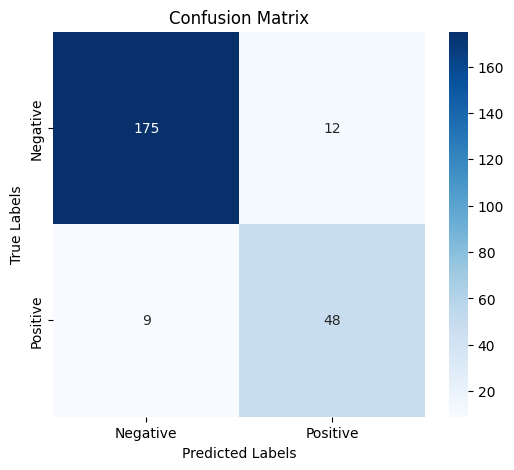

MODEL ACCURACY: 0.9139344262295082
MODEL PRECISION: 0.8
MODEL RECALL: 0.8421052631578947
MODEL F-SCORE: 0.8205128205128205


In [13]:
raw_model = BinaryClassifier(imb_train_df, target_name='Diagnosis', ridge_lambda=0.1, threshold=0.5, fit=True)

imb_valid_features = imb_valid_df.drop(columns=['Diagnosis']).values

raw_results = pd.DataFrame({
    'Diagnosis': imb_valid_df['Diagnosis'],
    'Prediction': raw_model.predict(imb_valid_features)
})

raw_model_stats = metrics.extract_results(raw_results)
metrics.print_metrics(raw_model_stats)

##### Undersampling

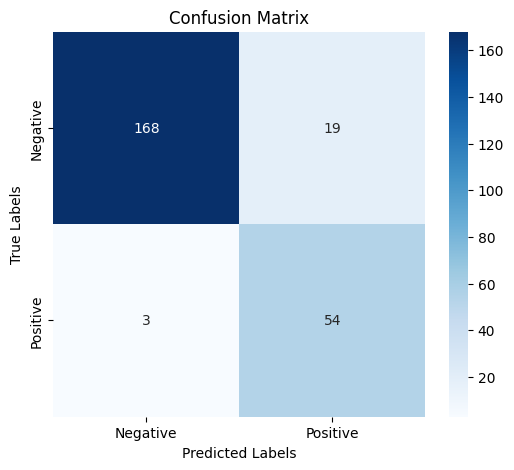

MODEL ACCURACY: 0.9098360655737705
MODEL PRECISION: 0.7397260273972602
MODEL RECALL: 0.9473684210526315
MODEL F-SCORE: 0.8307692307692308


In [14]:
us_train_df = rt.undersampling(imb_train_df, target_name='Diagnosis')
us_model = BinaryClassifier(us_train_df, target_name='Diagnosis', ridge_lambda=0.1, threshold=0.5, fit=True)

us_results = pd.DataFrame({
    'Diagnosis': imb_valid_df['Diagnosis'],
    'Prediction': us_model.predict(imb_valid_features)
})

us_model_stats = metrics.extract_results(us_results)
metrics.print_metrics(us_model_stats)

##### Oversampling mediante duplicación

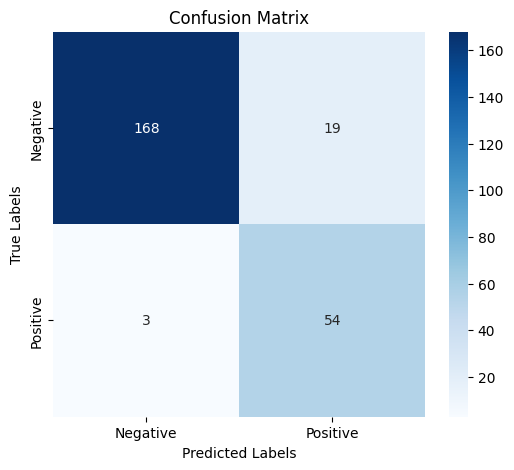

MODEL ACCURACY: 0.9098360655737705
MODEL PRECISION: 0.7397260273972602
MODEL RECALL: 0.9473684210526315
MODEL F-SCORE: 0.8307692307692308


In [15]:
duplicated_train_df = rt.duplication_oversampling(imb_train_df, target_name='Diagnosis')
do_model = BinaryClassifier(duplicated_train_df, target_name='Diagnosis', ridge_lambda=0.1, threshold=0.5, fit=True)

do_results = pd.DataFrame({
    'Diagnosis': imb_valid_df['Diagnosis'],
    'Prediction': do_model.predict(imb_valid_features)
})

do_model_stats = metrics.extract_results(do_results)
metrics.print_metrics(do_model_stats)

##### Oversampling mediante SMOTE

##### Cost re-weighting

## Wins Above Replacement ##

### Hacemos un análisis exploratorio de los datos